# ETL Project - Second Delivery (2do Corte)

---
## 1. Web Scraping Para Obtención De Datos

### 1. Web Scraping A La Primer Fuente De Verdad

In [4]:
import os
import json
import requests
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
from concurrent.futures import ThreadPoolExecutor
import traceback

# Cargar variables de entorno
load_dotenv()
API_KEY = os.getenv("LASTFM_API_KEY")
API_URL = "http://ws.audioscrobbler.com/2.0/"
DB_URI = os.getenv("DB_URI")

# Conexión BD
engine = create_engine(DB_URI)

# Carpeta cache
CACHE_DIR = "data/raw/lastfm"
os.makedirs(CACHE_DIR, exist_ok=True)

def fetch_track_info(artist, track):
    safe_artist = artist.replace("/", "_").replace(" ", "_")
    safe_track = track.replace("/", "_").replace(" ", "_")
    cache_file = os.path.join(CACHE_DIR, f"{safe_artist}__{safe_track}.json")

    if os.path.exists(cache_file):
        with open(cache_file, "r", encoding="utf-8") as f:
            content = f.read()
            if not content.strip():
                print(f" Archivo vacío: {cache_file}")
                return None
            try:
                return json.loads(content)
            except json.JSONDecodeError as e:
                print(f" Error al decodificar JSON en {cache_file}: {e}")
                return None

    params = {
        "method": "track.getInfo",
        "api_key": API_KEY,
        "artist": artist,
        "track": track,
        "format": "json"
    }

    try:
        response = requests.get(API_URL, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()

        with open(cache_file, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2, ensure_ascii=False)

        return data
    except Exception as e:
        print(f"Error consultando {artist} - {track}: {e}")
        return None

def parse_track_info(data):
    if not data or "track" not in data:
        return {
            "duration_ms": None,
            "album": "Unknown",
            "release_date": None,
            "listeners": 0,
            "playcount": 0,
            "tags": "Unknown"
        }

    t = data["track"]

    try:
        duration = int(t.get("duration", 0)) if t.get("duration") else None
    except ValueError:
        duration = None

    album = t.get("album", {}).get("title", "Unknown")
    release_date = t.get("wiki", {}).get("published", None)

    try:
        listeners = int(t.get("listeners", 0))
    except (ValueError, TypeError):
        listeners = 0

    try:
        playcount = int(t.get("playcount", 0))
    except (ValueError, TypeError):
        playcount = 0

    tags_list = t.get("toptags", {}).get("tag", [])
    if isinstance(tags_list, list):
        tags = ", ".join(tag["name"] for tag in tags_list[:3]) or "Unknown"
    else:
        tags = "Unknown"

    return {
        "duration_ms": duration,
        "album": album,
        "release_date": release_date,
        "listeners": listeners,
        "playcount": playcount,
        "tags": tags
    }

def enrich_row(row):
    artist = row.get("Artist") or row.get("artist")
    track = row.get("Track") or row.get("track")

    if not artist or not track:
        return None

    try:
        data = fetch_track_info(artist, track)
        parsed = parse_track_info(data)
        return {**row.to_dict(), **parsed}
    except Exception as e:
        print(f"Error en {artist} - {track}: {e}")
        traceback.print_exc()
        return None

def enrich_spotify_data():
    df = pd.read_sql("SELECT Artist, Track FROM spotify_most_streamed_clean", engine)
    print(f"🔄 Procesando {len(df)} filas...")

    with ThreadPoolExecutor(max_workers=10) as executor:
        enriched_rows = list(executor.map(enrich_row, df.itertuples(index=False)))

    enriched_rows = [row for row in enriched_rows if row is not None]
    df_enriched = pd.DataFrame(enriched_rows)

    df_enriched.to_sql("spotify_most_streamed_enriched", engine, if_exists="replace", index=False)
    print(" Datos enriquecidos guardados en 'spotify_most_streamed_enriched'.")

if __name__ == "__main__":
    try:
        enrich_spotify_data()
    finally:
        print(f" Cache '{CACHE_DIR}' conservado para acelerar futuras ejecuciones.")


PermissionError: [Errno 13] Permission denied: 'data'

---
## 2. Análisis Y Limpieza

### 1. Análisis Breve De Datos Enriquecidos

In [4]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

# 1. Cargar variables de entorno
load_dotenv()
DB_URI = os.getenv("DB_URI")
engine = create_engine(DB_URI)

# 2. Leer datos desde la tabla enriquecida
table_name = "spotify_most_streamed_enriched"
df = pd.read_sql(f"SELECT * FROM {table_name}", engine)

print("\n=== Resumen inicial de la tabla ===")
print(f"Filas: {df.shape[0]} | Columnas: {df.shape[1]}")
print(f"Columnas: {list(df.columns)}")

# 3. Conteo de nulos (NaN, None, NaT)
print("\n=== Conteo de valores nulos (NaN/None/NaT) ===")
print(df.isnull().sum())

# 4. Conteo de valores vacíos en columnas de texto
print("\n=== Conteo de valores vacíos o placeholders ===")
for col in df.select_dtypes(include=['object']).columns:
    empty_count = (df[col].astype(str).str.strip().isin(["", "Unknown", "N/A"])).sum()
    if empty_count > 0:
        print(f"{col}: {empty_count}")

# 5. Tipos de datos detectados
print("\n=== Tipos de datos ===")
print(df.dtypes)

# 6. Duplicados (por combinación de artista + track)
dups = df.duplicated(subset=["Artist", "Track"]).sum()
print(f"\nDuplicados por (Artist, Track): {dups}")

# 7. Estadísticas descriptivas de columnas numéricas
print("\n=== Estadísticas descriptivas (numéricas) ===")
print(df.describe())

# 8. Estadísticas básicas de columnas de texto
print("\n=== Estadísticas de columnas categóricas ===")
print(df.describe(include=['object']))

# 9. Muestra de filas
print("\n=== Muestra de registros ===")
print(df.sample(5, random_state=42))


=== Resumen inicial de la tabla ===
Filas: 4593 | Columnas: 35
Columnas: ['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC', 'All Time Rank', 'Track Score', 'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts', 'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach', 'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins', 'Deezer Playlist Count', 'Deezer Playlist Reach', 'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations', 'Soundcloud Streams', 'Shazam Counts', 'TIDAL Popularity', 'Explicit Track', 'duration_ms', 'album', 'release_date', 'listeners', 'playcount', 'tags']

=== Conteo de valores nulos (NaN/None/NaT) ===
Track                            0
Album Name                       0
Artist                           0
Release Date                     0
ISRC                             0
All Time Rank                    0
Track Score                      0
Spotif

### 2. Limpieza De Datos Enriquecidos

In [5]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Cargar variables de entorno
load_dotenv()
DB_URI = os.getenv("DB_URI")

# Conexión a la BD
engine = create_engine(DB_URI)

# Leer tabla enriquecida
df = pd.read_sql("SELECT * FROM spotify_most_streamed_enriched", engine)

print("=== Dataset original ===")
print(f"Filas: {len(df)}")

# 1. release_date → rellenar con "Unknown"
df["release_date"] = df["release_date"].fillna("Unknown")

# 2. duration_ms → eliminar registros inválidos (0 o <30s)
df = df[df["duration_ms"].isna() | (df["duration_ms"] >= 30000)]

# 3. duplicados (Artist + Track)
df = df.drop_duplicates(subset=["Artist", "Track"], keep="first")

print("=== Dataset limpio ===")
print(f"Filas: {len(df)}")

# Guardar en nueva tabla
df.to_sql("spotify_most_streamed_enriched_cleaned", engine, if_exists="replace", index=False)

print("Datos limpios guardados en 'spotify_most_streamed_enriched_cleaned'")


=== Dataset original ===
Filas: 4593
=== Dataset limpio ===
Filas: 3981
Datos limpios guardados en 'spotify_most_streamed_enriched_cleaned'


### 3. Análisis Profundo De Datos Enriquecidos Limpios


=== Resumen inicial de la tabla ===
Filas: 3981 | Columnas: 35
Columnas: ['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC', 'All Time Rank', 'Track Score', 'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts', 'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach', 'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins', 'Deezer Playlist Count', 'Deezer Playlist Reach', 'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations', 'Soundcloud Streams', 'Shazam Counts', 'TIDAL Popularity', 'Explicit Track', 'duration_ms', 'album', 'release_date', 'listeners', 'playcount', 'tags']

=== Conteo de valores nulos ===
Track                           0
Album Name                      0
Artist                          0
Release Date                    0
ISRC                            0
All Time Rank                   0
Track Score                     0
Spotify Streams             

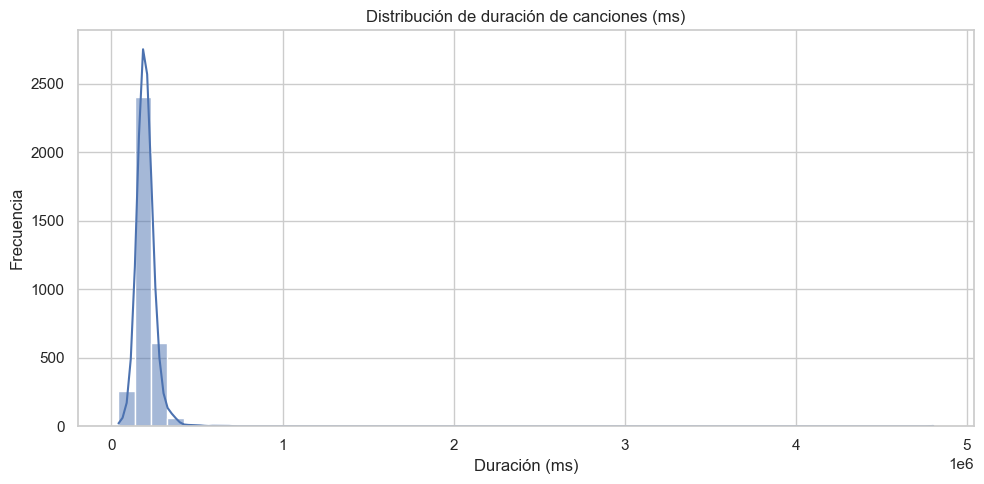

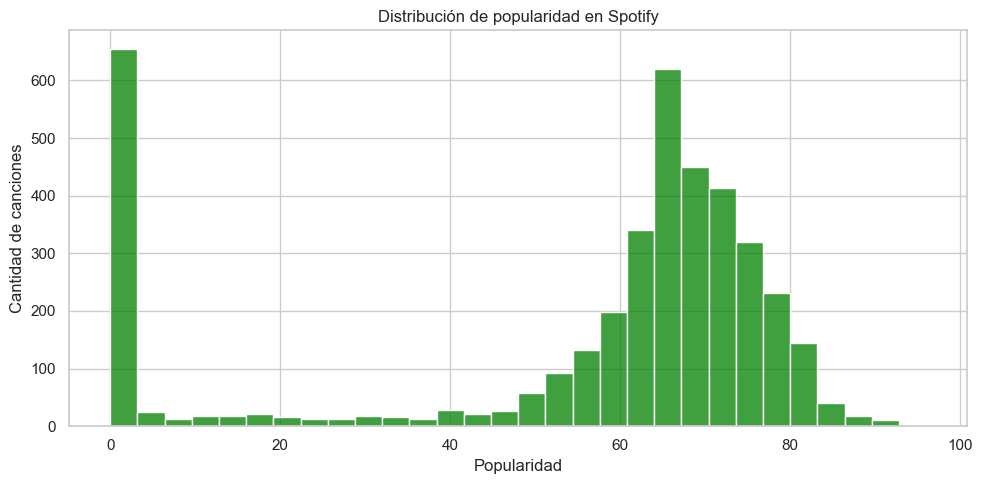


=== Top 15 artistas con más canciones ===
Artist
Taylor Swift      60
Drake             54
Bad Bunny         53
Billie Eilish     27
KAROL G           25
The Weeknd        25
Travis Scott      24
Ariana Grande     23
Future            22
Post Malone       20
Juice WRLD        19
Peso Pluma        19
Morgan Wallen     18
Rauw Alejandro    18
Kendrick Lamar    18
Name: count, dtype: int64


C:\Users\jonat\AppData\Local\Temp\ipykernel_26016\4228855933.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette="viridis")


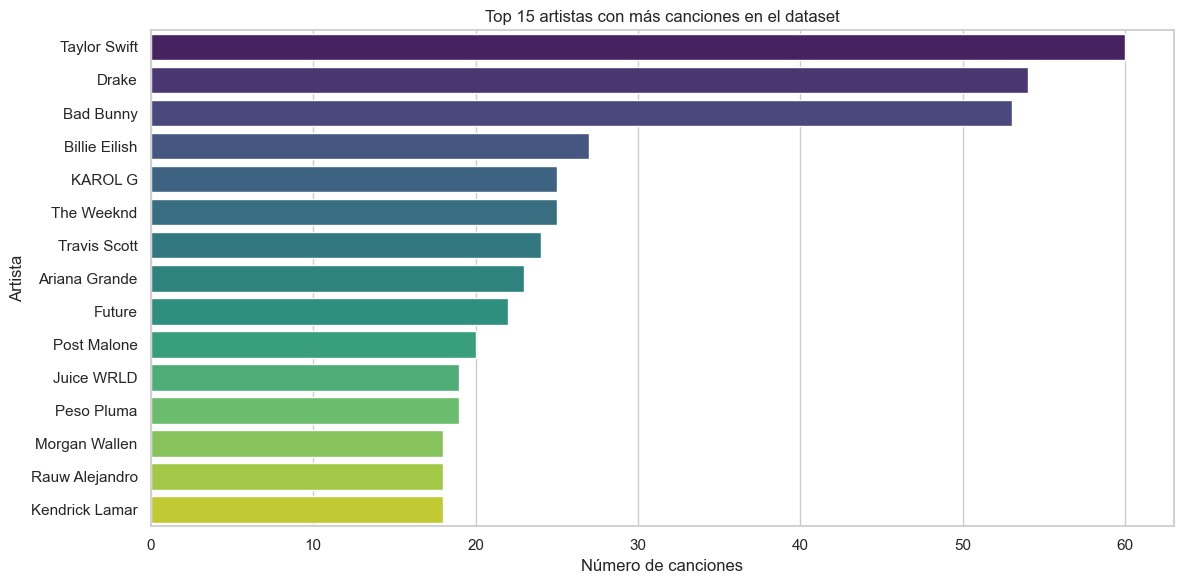


=== Correlación entre métricas numéricas ===


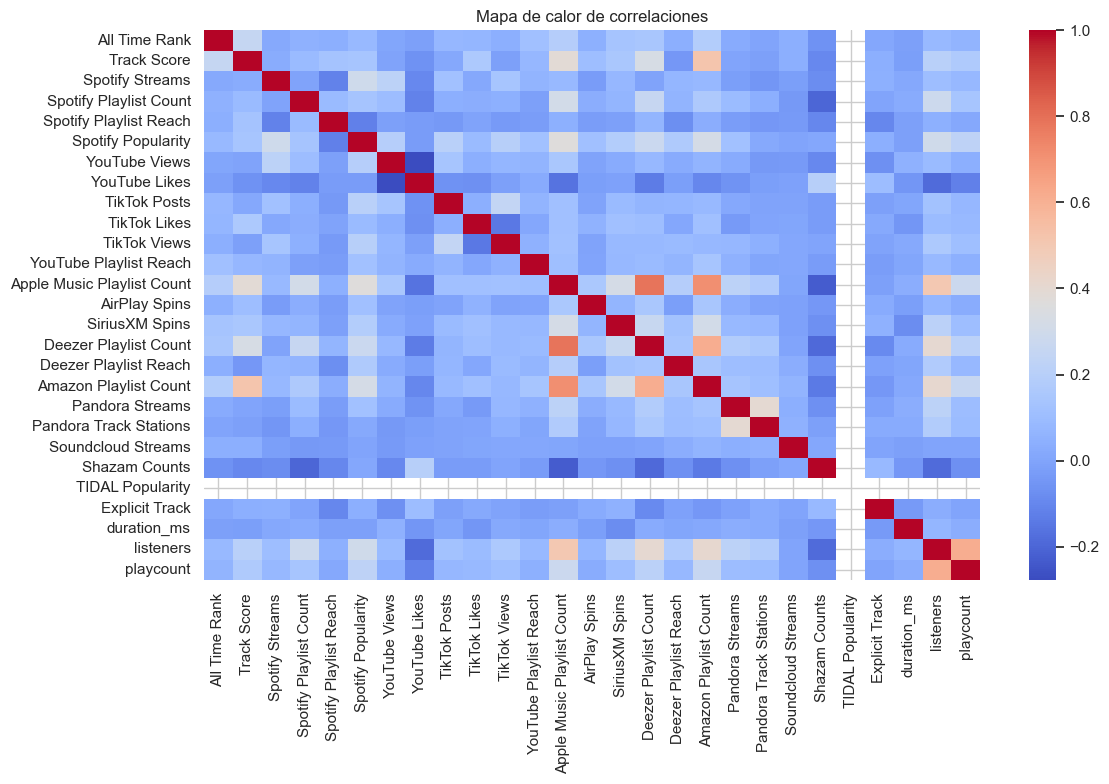


Canciones con release_date = 'Unknown': 2308


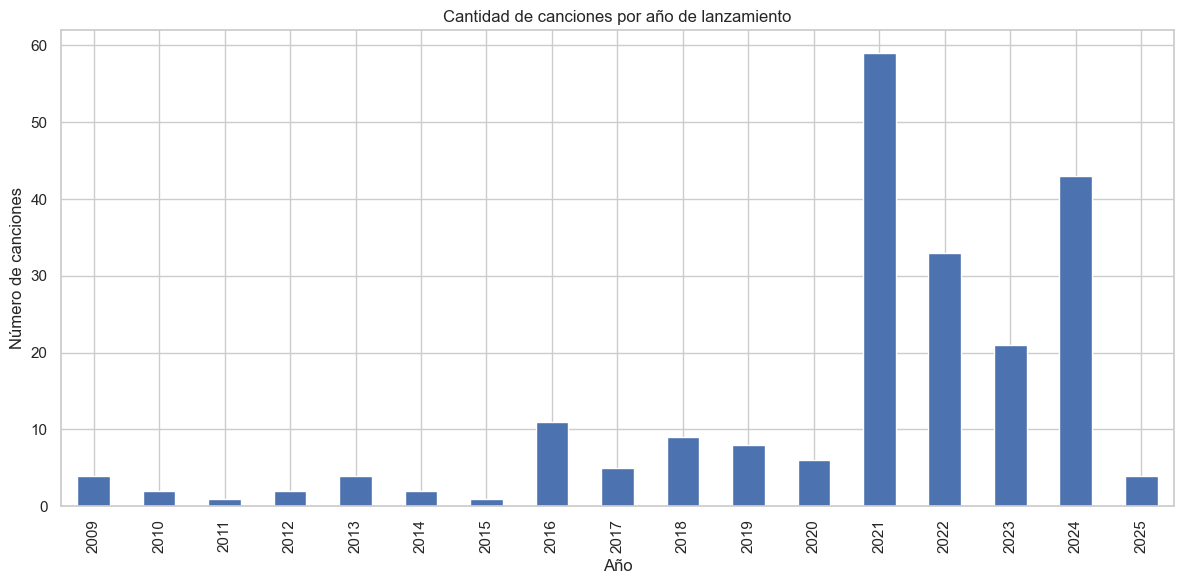

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Configuración de visualización
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

# Cargar variables de entorno
load_dotenv()
DB_URI = os.getenv("DB_URI")

# Conexión a la BD
engine = create_engine(DB_URI)

# Leer tabla limpia
df = pd.read_sql("SELECT * FROM spotify_most_streamed_enriched_cleaned", engine)

print("\n=== Resumen inicial de la tabla ===")
print(f"Filas: {len(df)} | Columnas: {len(df.columns)}")
print(f"Columnas: {list(df.columns)}")

# --- 1. Conteo de nulos ---
print("\n=== Conteo de valores nulos ===")
print(df.isnull().sum())

# --- 2. Conteo de Unknown ---
print("\n=== Conteo de valores 'Unknown' ===")
unknown_counts = (df == "Unknown").sum()
print(unknown_counts[unknown_counts > 0])

# --- 3. Tipos de datos ---
print("\n=== Tipos de datos por columna ===")
print(df.dtypes)

# --- 4. Consistencia de duración ---
print("\n=== Estadísticas de duración (ms) ===")
print(df["duration_ms"].describe())

# Gráfica de distribución de duración
plt.figure(figsize=(10, 5))
sns.histplot(df["duration_ms"].dropna(), bins=50, kde=True)
plt.title("Distribución de duración de canciones (ms)")
plt.xlabel("Duración (ms)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# --- 5. Popularidad en Spotify ---
plt.figure(figsize=(10, 5))
sns.histplot(df["Spotify Popularity"], bins=30, kde=False, color="green")
plt.title("Distribución de popularidad en Spotify")
plt.xlabel("Popularidad")
plt.ylabel("Cantidad de canciones")
plt.tight_layout()
plt.show()

# --- 6. Top 15 artistas con más canciones en el dataset ---
top_artists = df["Artist"].value_counts().head(15)
print("\n=== Top 15 artistas con más canciones ===")
print(top_artists)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_artists.values, y=top_artists.index, palette="viridis")
plt.title("Top 15 artistas con más canciones en el dataset")
plt.xlabel("Número de canciones")
plt.ylabel("Artista")
plt.tight_layout()
plt.show()

# --- 7. Correlación entre métricas numéricas ---
print("\n=== Correlación entre métricas numéricas ===")
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Mapa de calor de correlaciones")
plt.tight_layout()
plt.show()

# --- 8. Conteo de Unknown en release_date ---
unknown_dates = (df["release_date"] == "Unknown").sum()
print(f"\nCanciones con release_date = 'Unknown': {unknown_dates}")

# --- 9. Distribución temporal (solo las que tienen fecha válida) ---
df_dates = df[df["release_date"] != "Unknown"].copy()
df_dates["release_date"] = pd.to_datetime(df_dates["release_date"], errors="coerce")
df_dates = df_dates.dropna(subset=["release_date"])

plt.figure(figsize=(12, 6))
df_dates["release_date"].dt.year.value_counts().sort_index().plot(kind="bar")
plt.title("Cantidad de canciones por año de lanzamiento")
plt.xlabel("Año")
plt.ylabel("Número de canciones")
plt.tight_layout()
plt.show()


### 4. Limpieza y Análisis De Datos Después Del Análisis De La Primera Limpieza

In [5]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv
from autoviz.AutoViz_Class import AutoViz_Class

# Cargar variables de entorno
load_dotenv()
DB_URI = os.getenv("DB_URI")

# Conexión a la BD
engine = create_engine(DB_URI)

# 2. Cargar tabla
df = pd.read_sql("SELECT * FROM spotify_most_streamed_enriched_cleaned;", engine)

print(f"Tabla cargada: {df.shape[0]} filas, {df.shape[1]} columnas")

# 3. Limpieza básica
# 3.1 Reemplazar "Unknown" con NaN en columnas relevantes
cols_unknown = ["album", "release_date", "tags"]
for col in cols_unknown:
    if col in df.columns:
        df[col] = df[col].replace("Unknown", np.nan)

# 3.2 Unificar fechas
if "Release Date" in df.columns and "release_date" in df.columns:
    df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
    df["Release Date"] = pd.to_datetime(df["Release Date"], errors="coerce")
    df["release_date"] = df["release_date"].fillna(df["Release Date"])
    df.drop(columns=["Release Date"], inplace=True)

# 3.3 Duración: eliminar outliers (<30s o >15min)
if "duration_ms" in df.columns:
    df = df[
        (df["duration_ms"].fillna(0) >= 30_000) &
        (df["duration_ms"].fillna(0) <= 900_000)
    ]

# 3.4 Eliminar duplicados por artista + track
if all(c in df.columns for c in ["Track", "Artist"]):
    df.drop_duplicates(subset=["Track", "Artist"], inplace=True)

# 4. Mostrar análisis rápido con AutoViz
AV = AutoViz_Class()
AV.AutoViz(
    filename="",
    dfte=df,
    depVar="",
    verbose=1
)


Tabla cargada: 3981 filas, 35 columnas
Shape of your Data Set loaded: (3341, 34)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  22
    Number of Integer-Categorical Columns =  3
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  1
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  5
    Number of Date Time Columns =  1
    Number of ID Columns =  1
    Number of Columns to Delete =  1
    34 Predictors classified...
        2 variable(s) removed since they were ID or low-information variables
        List of variables removed: ['ISRC', 'TIDAL Popularity']

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Track,object,0.000000,97,,,No issue
Album Name,object,0.000000,87,,,No issue
Artist,object,0.000000,43,,,No issue
ISRC,object,0.000000,100,,,Possible ID column: drop before modeling step.
All Time Rank,int64,0.000000,23,1.000000,998.000000,Column has 762 outliers greater than upper bound (7.00) or lower than lower bound(-1.00). Cap them or remove them.
Track Score,float64,0.000000,NA,19.400000,725.400000,Column has 301 outliers greater than upper bound (79.25) or lower than lower bound(-9.95). Cap them or remove them.
Spotify Streams,float64,0.000000,NA,0.000000,999.000000,No issue
Spotify Playlist Count,float64,0.000000,NA,0.000000,992.000000,Column has 182 outliers greater than upper bound (251.00) or lower than lower bound(-125.00). Cap them or remove them.
Spotify Playlist Reach,float64,0.000000,NA,0.000000,999.000000,Column has 316 outliers greater than upper bound (88.00) or lower than lower bound(-40.00). Cap them or remove them.
Spotify Popularity,float64,0.000000,NA,0.000000,96.000000,Column has 618 outliers greater than upper bound (99.00) or lower than lower bound(27.00). Cap them or remove them.


Number of All Scatter Plots = 253


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

Could not draw wordcloud plot for Track. 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.

Could not draw wordcloud plot for Album Name. 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.

Could not draw wordcloud plot for Artist. 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://

,Track,Album Name,Artist,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,TikTok Posts,TikTok Likes,TikTok Views,YouTube Playlist Reach,Apple Music Playlist Count,AirPlay Spins,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track,duration_ms,album,release_date,listeners,playcount,tags
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,QM24S2402528,1,725.4,390.0,30.0,196.0,92.0,84.0,1.0,5.0,651.0,5.0,150.0,210.0,40.0,684.0,62.0,17.0,114.0,18.0,22.0,4.0,2.0,0.0,0,155000.0,Million Dollar Baby,2024-05-15 23:46:00,1265998,15179670,"instrumental, melodic, danceable"
1,Not Like Us,Not Like Us,Kendrick Lamar,USUG12400910,2,545.9,323.0,28.0,174.0,92.0,116.0,3.0,674.0,35.0,208.0,156.0,188.0,40.0,3.0,67.0,10.0,111.0,7.0,28.0,6.0,1.0,0.0,1,274000.0,Not Like Us,2024-05-05 21:35:00,1784489,27222312,"Diss, instrumental, Hip-Hop"
2,i like the way you kiss me,I like the way you kiss me,Artemas,QZJ842400387,3,538.4,601.0,54.0,211.0,92.0,122.0,2.0,3.0,275.0,3.0,373.0,190.0,74.0,536.0,136.0,36.0,172.0,5.0,5.0,7.0,5.0,0.0,0,143000.0,i like the way you kiss me,2024-03-19 00:00:00,1089589,14921256,"coldwave, post-punk, synthpop"
3,Flowers,Flowers - Single,Miley Cyrus,USSM12209777,4,444.9,2.0,269.0,136.0,85.0,1.0,10.0,7.0,1.0,14.0,3.0,394.0,1.0,2.0,264.0,24.0,210.0,190.0,203.0,0.0,11.0,0.0,0,200000.0,Flowers,2023-01-12 00:00:00,1114028,14818407,"pop, 2023, Disco"
4,Houdini,Houdini,Eminem,USUG12403398,5,423.3,107.0,7.0,151.0,88.0,77.0,3.0,16.0,0.0,0.0,112.0,182.0,12.0,1.0,82.0,17.0,105.0,4.0,7.0,207.0,457.0,0.0,1,227000.0,Houdini,2024-05-31 13:58:00,623237,6274677,"hip hop, 2024, Hip-Hop"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3972,Daylight,Harry's House,Harry Styles,USSM12200613,4,19.5,377.0,42.0,11.0,68.0,46.0,1.0,80.0,39.0,224.0,62.0,21.0,4.0,218.0,22.0,581.0,8.0,20.0,4.0,165.0,224.0,0.0,0,164000.0,Harry’s House,2022-05-21 20:23:00,661935,10313770,"pop, rock, pop rock"
3973,Happiest Year,Feel Something (Deluxe),Jaymes Young,USAT21903715,4,19.5,472.0,84.0,23.0,69.0,181.0,2.0,2.0,440.0,3.0,140.0,33.0,563.0,13.0,10.0,101.0,1.0,10.0,18.0,0.0,1.0,0.0,0,228000.0,Just Hits,2017-06-23 00:00:00,265026,2038467,NaN
3977,For the Last Time,For the Last Time,$uicideboy$,QM8DG1703420,4,19.4,305.0,65.0,5.0,71.0,149.0,1.0,48.0,20.0,143.0,53.0,3.0,6.0,0.0,2.0,14.0,0.0,20.0,13.0,50.0,656.0,0.0,1,156000.0,KILL YOURSELF PART XX: THE INFINITY SAGA,2017-09-05 00:00:00,363114,6180127,"Hip-Hop, rap, emo"
3978,Dil Meri Na Sune,"Dil Meri Na Sune (From ""Genius"")",Atif Aslam,INT101800122,4,19.4,52.0,4.0,1.0,56.0,943.0,5.0,0.0,1.0,19.0,24.0,1.0,412.0,0.0,1.0,927.0,0.0,0.0,0.0,0.0,193.0,0.0,0,236000.0,Genius (Original Motion Picture Soundtrack),2018-07-27 00:00:00,7652,33357,NaN


---
## 3. Consultas SQL Y Visualizaciones

### 1. Consultas SQL

In [12]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Cargar variables de entorno
load_dotenv()
DB_URI = os.getenv("DB_URI")

# Conexión a la BD
engine = create_engine(DB_URI)

# Carpeta de salida
output_dir = os.path.join("..", "reports", "sql_results")
os.makedirs(output_dir, exist_ok=True)

# -------------------------------
# 1. Top N canciones por Spotify Streams
# -------------------------------
query_1 = """
SELECT "Track", "Artist", "Spotify Streams"
FROM spotify_most_streamed_enriched_cleaned
ORDER BY "Spotify Streams" DESC
LIMIT 10;
"""
df1 = pd.read_sql(query_1, engine)
df1.to_csv(os.path.join(output_dir, "01_top_tracks.csv"), index=False)

# -------------------------------
# 2. Evolución por fecha de lanzamiento
# -------------------------------
query_2 = """
SELECT DATE_TRUNC('month', "Release Date") AS month, SUM("Spotify Streams") AS total_streams
FROM spotify_most_streamed_enriched_cleaned
GROUP BY month
ORDER BY month;
"""
df2 = pd.read_sql(query_2, engine)
df2.to_csv(os.path.join(output_dir, "02_streams_evolution.csv"), index=False)

# -------------------------------
# 3. Distribución por Playlist Count (Spotify)
# -------------------------------
query_3 = """
SELECT "Spotify Playlist Count", COUNT(*) AS track_count
FROM spotify_most_streamed_enriched_cleaned
GROUP BY "Spotify Playlist Count"
ORDER BY track_count DESC;
"""
df3 = pd.read_sql(query_3, engine)
df3.to_csv(os.path.join(output_dir, "03_playlist_distribution.csv"), index=False)

# -------------------------------
# 4. Relación duración ↔ popularidad
# -------------------------------
query_4 = """
SELECT "duration_ms", "Spotify Popularity"
FROM spotify_most_streamed_enriched_cleaned
WHERE "duration_ms" IS NOT NULL AND "Spotify Popularity" IS NOT NULL;
"""
df4 = pd.read_sql(query_4, engine)
df4.to_csv(os.path.join(output_dir, "04_duration_popularity.csv"), index=False)

# -------------------------------
# 5. Ranking por artista según Spotify Streams
# -------------------------------
query_5 = """
SELECT "Artist", SUM("Spotify Streams") AS total_streams
FROM spotify_most_streamed_enriched_cleaned
GROUP BY "Artist"
ORDER BY total_streams DESC
LIMIT 10;
"""
df5 = pd.read_sql(query_5, engine)
df5.to_csv(os.path.join(output_dir, "05_top_artists.csv"), index=False)

# -------------------------------
# 6. Comparación multicanal (Spotify, YouTube, TikTok)
# -------------------------------
query_6 = """
SELECT "Track", "Artist", "Spotify Streams", "YouTube Views", "TikTok Views"
FROM spotify_most_streamed_enriched_cleaned
ORDER BY "Spotify Streams" DESC
LIMIT 10;
"""
df6 = pd.read_sql(query_6, engine)
df6.to_csv(os.path.join(output_dir, "06_multichannel.csv"), index=False)

print("Consultas ejecutadas y CSVs guardados en:", output_dir)


Consultas ejecutadas y CSVs guardados en: ..\reports\sql_results


### 2. Visualizaciones

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv

# -------------------------------
# Configuración
# -------------------------------
load_dotenv()
DB_URI = os.getenv("DB_URI")
engine = create_engine(DB_URI)

# Carpeta de salida para figuras
figures_dir = os.path.join("..", "reports", "figures")
os.makedirs(figures_dir, exist_ok=True)

# Cargar tabla completa
df = pd.read_sql('SELECT * FROM spotify_most_streamed_enriched_cleaned', engine)

# Asegurarse de que release_date sea datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# -------------------------------
# 1. Top artistas por Spotify Streams (Bar Plot)
# -------------------------------
top_artists = df.groupby('Artist')['Spotify Streams'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.xlabel('Spotify Streams')
plt.ylabel('Artist')
plt.title('Top 10 Artistas por Spotify Streams')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '01_top_artists.png'))
plt.close()

# -------------------------------
# 2. Evolución de Streams por mes (Line Plot)
# -------------------------------
monthly_streams = df.groupby(df['release_date'].dt.to_period('M'))['Spotify Streams'].sum()
plt.figure(figsize=(14,6))
monthly_streams.plot(marker='o')
plt.xlabel('Mes de lanzamiento')
plt.ylabel('Spotify Streams')
plt.title('Evolución de Spotify Streams por fecha de lanzamiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '02_streams_evolution.png'))
plt.close()

# -------------------------------
# 3. Duración vs Popularidad (Scatter Plot)
# -------------------------------
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='duration_ms', y='Spotify Popularity', alpha=0.6)
plt.xlabel('Duración (ms)')
plt.ylabel('Spotify Popularity')
plt.title('Relación entre duración de la canción y popularidad')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '03_duration_popularity.png'))
plt.close()

# -------------------------------
# 4. Correlación multicanal (Heatmap)
# -------------------------------
corr_cols = ['Spotify Streams', 'YouTube Views', 'TikTok Views', 'Apple Music Playlist Count']
plt.figure(figsize=(8,6))
sns.heatmap(df[corr_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlación de Popularidad Multicanal')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '04_multichannel_correlation.png'))
plt.close()

print("Figuras guardadas en:", os.path.abspath(figures_dir))


Figuras guardadas en: c:\Users\jonat\Downloads\Proyecto_2\reports\figures


---
## 4. Análisis De La Base De Datos - PostgreSQL En Railway

### 1. Análisis En Texto

In [26]:
import os
from sqlalchemy import create_engine, inspect
from dotenv import load_dotenv

# Cargar variables de entorno
load_dotenv()
DB_URI = os.getenv("DB_URI")

# Conexión a la BD
engine = create_engine(DB_URI)
inspector = inspect(engine)

# Tablas de interés
tables = [
    "spotify_most_streamed_2024",
    "spotify_most_streamed_clean",
    "spotify_most_streamed_enriched",
    "spotify_most_streamed_enriched_cleaned"
]

# Función para obtener número de filas de una tabla
def get_row_count(table_name):
    with engine.connect() as conn:
        result = conn.exec_driver_sql(f'SELECT COUNT(*) FROM "{table_name}"')
        return result.scalar()

# Función para imprimir columnas y tipos
def print_columns(table_name):
    columns = inspector.get_columns(table_name)
    for col in columns:
        name = col['name']
        dtype = str(col['type'])
        print(f"    - {name} ({dtype})")

# Resumen en terminal
print("="*60)
print("RESUMEN DE TABLAS Y ESTRUCTURA (MODELO DIMENSIONAL)")
print("="*60)

for table in tables:
    print(f"\nTabla: {table}")
    print("-"*60)
    try:
        rows = get_row_count(table)
        print(f"Número de filas: {rows}")
        print("Columnas:")
        print_columns(table)
    except Exception as e:
        print(f"Error accediendo tabla {table}: {e}")

print("\nFlujo conceptual ETL:")
print("spotify_most_streamed_2024 -> spotify_most_streamed_cleaned -> "
        "spotify_most_streamed_enriched -> spotify_most_streamed_enriched_clean")
print("="*60)
print("Fin del resumen")


RESUMEN DE TABLAS Y ESTRUCTURA (MODELO DIMENSIONAL)

Tabla: spotify_most_streamed_2024
------------------------------------------------------------
Número de filas: 4600
Columnas:
    - Track (TEXT)
    - Album Name (TEXT)
    - Artist (TEXT)
    - Release Date (DATE)
    - ISRC (VARCHAR(20))
    - All Time Rank (INTEGER)
    - Track Score (NUMERIC)
    - Spotify Streams (BIGINT)
    - Spotify Playlist Count (INTEGER)
    - Spotify Playlist Reach (BIGINT)
    - Spotify Popularity (NUMERIC)
    - YouTube Views (BIGINT)
    - YouTube Likes (BIGINT)
    - TikTok Posts (BIGINT)
    - TikTok Likes (BIGINT)
    - TikTok Views (BIGINT)
    - YouTube Playlist Reach (BIGINT)
    - Apple Music Playlist Count (INTEGER)
    - AirPlay Spins (BIGINT)
    - SiriusXM Spins (BIGINT)
    - Deezer Playlist Count (INTEGER)
    - Deezer Playlist Reach (BIGINT)
    - Amazon Playlist Count (INTEGER)
    - Pandora Streams (BIGINT)
    - Pandora Track Stations (BIGINT)
    - Soundcloud Streams (BIGINT)
    - S

### 2. Análisis Con Gráficos

In [25]:
import os
import plotext as plt
from sqlalchemy import create_engine, inspect, text
from dotenv import load_dotenv

load_dotenv()
DB_URI = os.getenv("DB_URI")
engine = create_engine(DB_URI)
inspector = inspect(engine)

TABLES = [
    "spotify_most_streamed_2024",
    "spotify_most_streamed_clean",
    "spotify_most_streamed_enriched",
    "spotify_most_streamed_enriched_cleaned"
]

for table in TABLES:
    try:
        with engine.connect() as conn:
            count = conn.execute(text(f'SELECT COUNT(*) FROM "{table}"')).scalar()

        columns = inspector.get_columns(table)
        type_counts = {}
        for col in columns:
            t = str(col['type'])
            type_counts[t] = type_counts.get(t, 0) + 1

        # Graficar la distribución de tipos de columnas
        plt.clear_data()
        plt.bar(list(type_counts.keys()), list(type_counts.values()), orientation="vertical")
        plt.title(f"{table} (Filas: {count})")
        plt.show()

    except Exception as e:
        print(f"Error accediendo tabla {table}: {e}")


                      spotify_most_streamed_2024 (Filas: 4600)                  
    ┌──────────────────────────────────────────────────────────────────────────┐
15.0┤                                                      █████████           │
    │                                                      █████████           │
    │                                                      █████████           │
12.5┤                                                      █████████           │
    │                                                      █████████           │
    │                                                      █████████           │
10.0┤                                                      █████████           │
    │                                                      █████████           │
 7.5┤                                                      █████████           │
    │                                                      █████████           │
    │                       

---
## 5. Great Expectations

### 1. Cargar Dataset Y Clase SimpleGE

In [5]:
import pandas as pd
import os
from datetime import datetime
import json

# Cargar dataset
df = pd.read_csv("../data/curated/spotify_most_streamed_enriched_cleaned.csv")

# Clase SimpleGE
class SimpleGE:
    def __init__(self, df):
        self.df = df
        self.results = []

    def _store_result(self, expectation_type, success, details=None):
        self.results.append({
            "expectation": expectation_type,
            "success": success,
            "details": details
        })

    def expect_table_row_count_to_be_between(self, min_value=None, max_value=None):
        count = len(self.df)
        success = True
        if min_value is not None and count < min_value:
            success = False
        if max_value is not None and count > max_value:
            success = False
        self._store_result("expect_table_row_count_to_be_between", success, {"count": count})
        return success

    def expect_table_column_count_to_equal(self, value):
        count = self.df.shape[1]
        success = (count == value)
        self._store_result("expect_table_column_count_to_equal", success, {"count": count})
        return success

    def expect_table_columns_to_match_set(self, expected_columns):
        cols = set(self.df.columns)
        success = (cols == set(expected_columns))
        self._store_result("expect_table_columns_to_match_set", success, {
            "missing": set(expected_columns) - cols,
            "extra": cols - set(expected_columns)
        })
        return success

    def expect_column_values_to_not_be_null(self, column):
        nulls = self.df[column].isnull().sum()
        success = (nulls == 0)
        self._store_result("expect_column_values_to_not_be_null", success, {"nulls": int(nulls)})
        return success

    def expect_column_min_to_be_between(self, column, min_value=None, max_value=None):
        min_val = self.df[column].min()
        success = True
        if min_value is not None and min_val < min_value:
            success = False
        if max_value is not None and min_val > max_value:
            success = False
        self._store_result("expect_column_min_to_be_between", success, {"min": float(min_val)})
        return success

    def expect_column_values_to_be_between(self, column, min_value=None, max_value=None, mostly=1.0):
        valid = self.df[column].between(min_value, max_value).mean()
        success = (valid >= mostly)
        self._store_result("expect_column_values_to_be_between", success, {"proportion_valid": float(valid)})
        return success

    def expect_column_values_to_be_in_set(self, column, value_set):
        valid = self.df[column].isin(value_set).mean()
        success = (valid == 1.0)
        self._store_result("expect_column_values_to_be_in_set", success, {"proportion_valid": float(valid)})
        return success

    def expect_column_value_lengths_to_be_between(self, column, min_value=None, max_value=None):
        lengths = self.df[column].astype(str).str.len()
        valid = lengths.between(min_value, max_value).mean()
        success = (valid == 1.0)
        self._store_result("expect_column_value_lengths_to_be_between", success, {"proportion_valid": float(valid)})
        return success

    def validate(self):
        return {"results": self.results}

# Instanciar validador
validator = SimpleGE(df)

### 2. Expectativas Básicas

In [6]:
# Filas y columnas
validator.expect_table_row_count_to_be_between(min_value=3900, max_value=4100)
validator.expect_table_column_count_to_equal(35)

# Columnas esperadas
expected_columns = [
    'Track','Album Name','Artist','Release Date','ISRC','All Time Rank',
    'Track Score','Spotify Streams','Spotify Playlist Count','Spotify Playlist Reach',
    'Spotify Popularity','YouTube Views','YouTube Likes','TikTok Posts',
    'TikTok Likes','TikTok Views','YouTube Playlist Reach',
    'Apple Music Playlist Count','AirPlay Spins','SiriusXM Spins',
    'Deezer Playlist Count','Deezer Playlist Reach','Amazon Playlist Count',
    'Pandora Streams','Pandora Track Stations','Soundcloud Streams',
    'Shazam Counts','TIDAL Popularity','Explicit Track','duration_ms',
    'album','release_date','listeners','playcount','tags'
]
validator.expect_table_columns_to_match_set(expected_columns)

# Campos clave sin nulos
for col in ["Track", "Album Name", "Artist", "ISRC"]:
    validator.expect_column_values_to_not_be_null(col)

### 3. Expectativas Intermedias

In [7]:
# Numéricos >= 0
numeric_cols = [
    'All Time Rank','Track Score','Spotify Streams','Spotify Playlist Count',
    'Spotify Playlist Reach','Spotify Popularity','YouTube Views',
    'YouTube Likes','TikTok Posts','TikTok Likes','TikTok Views',
    'YouTube Playlist Reach','Apple Music Playlist Count','AirPlay Spins',
    'SiriusXM Spins','Deezer Playlist Count','Deezer Playlist Reach',
    'Amazon Playlist Count','Pandora Streams','Pandora Track Stations',
    'Soundcloud Streams','Shazam Counts','TIDAL Popularity','listeners',
    'playcount'
]
for col in numeric_cols:
    validator.expect_column_min_to_be_between(col, min_value=0)

# Duración razonable
validator.expect_column_values_to_be_between("duration_ms", min_value=40000, max_value=5000000, mostly=0.95)

# Explicit Track debe ser 0 o 1
validator.expect_column_values_to_be_in_set("Explicit Track", [0, 1])

True

### 4. Expectativas Avanzadas

In [8]:
# Longitud de cadenas controlada
for col in ["album", "release_date", "tags"]:
    validator.expect_column_value_lengths_to_be_between(col, min_value=0, max_value=255)

# Popularidad en rango razonable
validator.expect_column_values_to_be_between("Spotify Popularity", min_value=0, max_value=100, mostly=1.0)

# Ranking en orden lógico
validator.expect_column_min_to_be_between("All Time Rank", min_value=1)

# Streams correlación indirecta (aproximación simple)
validator.expect_column_min_to_be_between("Spotify Streams", min_value=1000)

False

### 5. Validación, Guardado y Reporte

In [14]:
from pathlib import Path
import json
import numpy as np
from datetime import datetime

# Validación final
results = validator.validate()

# Normalizar resultados para JSON
def normalize(obj):
    if isinstance(obj, set):
        return list(obj)
    if isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    if isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    if isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    if isinstance(obj, dict):
        return {k: normalize(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [normalize(v) for v in obj]
    return obj

results = normalize(results)

# Determinar raíz del proyecto buscando carpeta 'data'
cwd = Path.cwd()
if (cwd / "data").exists():
    project_root = cwd
elif (cwd.parent / "data").exists():
    project_root = cwd.parent
else:
    project_root = cwd.parent

# Ruta de reportes en la raíz del proyecto
reports_dir = project_root / "reports" / "great_expectations"
reports_dir.mkdir(parents=True, exist_ok=True)

# Nombres con timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
json_path = reports_dir / f"validation_report_{timestamp}.json"
html_path = reports_dir / f"validation_report_{timestamp}.html"
summary_path = reports_dir / f"summary_{timestamp}.txt"

# Guardar JSON
with open(json_path, "w") as f:
    json.dump(results, f, indent=4)
print(f"Archivo JSON guardado correctamente en: {json_path}")

# Guardar HTML
with open(html_path, "w") as f:
    f.write("<html><head><title>Validation Report</title></head><body>")
    f.write("<h1>Validation Report</h1>")
    for r in results["results"]:
        color = "green" if r["success"] else "red"
        f.write(f"<p><b>{r['expectation']}</b>: <span style='color:{color}'>{r['success']}</span> - {r['details']}</p>")
    f.write("</body></html>")
print(f"Archivo HTML guardado correctamente en: {html_path}")

# Resumen en terminal
total = len(results["results"])
passed = sum(1 for r in results["results"] if r["success"])
failed = total - passed

summary = []
summary.append("="*50)
summary.append("VALIDATION SUMMARY")
summary.append("="*50)
summary.append(f"Total checks: {total}")
summary.append(f"Passed:       {passed}")
summary.append(f"Failed:       {failed}")
summary.append("-"*50)
for r in results["results"]:
    status = "PASS" if r["success"] else "FAIL"
    summary.append(f"{status:6} | {r['expectation']} | {r['details']}")
summary.append("="*50)

summary_text = "\n".join(summary)
print(summary_text)

# Guardar resumen a archivo
with open(summary_path, "w") as f:
    f.write(summary_text)

Archivo JSON guardado correctamente en: c:\Users\jonat\Downloads\Proyecto_2\reports\great_expectations\validation_report_20250927_151352.json
Archivo HTML guardado correctamente en: c:\Users\jonat\Downloads\Proyecto_2\reports\great_expectations\validation_report_20250927_151352.html
VALIDATION SUMMARY
Total checks: 40
Passed:       38
Failed:       2
--------------------------------------------------
PASS   | expect_table_row_count_to_be_between | {'count': 3981}
PASS   | expect_table_column_count_to_equal | {'count': 35}
PASS   | expect_table_columns_to_match_set | {'missing': [], 'extra': []}
PASS   | expect_column_values_to_not_be_null | {'nulls': 0}
PASS   | expect_column_values_to_not_be_null | {'nulls': 0}
PASS   | expect_column_values_to_not_be_null | {'nulls': 0}
PASS   | expect_column_values_to_not_be_null | {'nulls': 0}
PASS   | expect_column_min_to_be_between | {'min': 1.0}
PASS   | expect_column_min_to_be_between | {'min': 19.4}
PASS   | expect_column_min_to_be_between | {'